# Encoding an image in an image

In [47]:
# Imports
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [48]:
def apply_key(binary, key):
    """Apply XOR operation to binary data with a repeating key."""
    # Ensure the key repeats to match the length of the binary data
    repeated_key = (key * (len(binary) // len(key) + 1))[:len(binary)]
    return ''.join(str(int(b) ^ int(k)) for b, k in zip(binary, repeated_key))

def crop_and_resize_img(img, target_dimensions):
    """Crop and resize image to target dimensions."""
    original_width, original_height = img.size
    target_ratio = target_dimensions[0] / target_dimensions[1]
    original_ratio = original_width / original_height

    # Determine dimensions to crop to maintain aspect ratio
    if original_ratio > target_ratio:
        # Crop width to fit the new ratio
        new_width = int(original_height * target_ratio)
        new_height = original_height
    else:
        # Crop height to fit the new ratio
        new_width = original_width
        new_height = int(original_width / target_ratio)

    # Center cropping to the new dimensions
    left = (original_width - new_width) / 2
    top = (original_height - new_height) / 2
    right = (original_width + new_width) / 2
    bottom = (original_height + new_height) / 2

    img = img.crop((left, top, right, bottom))
    img = img.resize(target_dimensions, Image.LANCZOS)  # Resize to target dimensions using high-quality downsampling
    return img

def image_to_bin(img):
    """Convert the pixels of an image to binary."""
    img = img.convert('RGB')  # Ensure the image is in RGB mode
    # Flatten the image data and convert each pixel to binary
    binary = ''.join(format(pixel, '08b') for pixel in np.array(img).flatten())
    return binary

def encode_image(cover_path, secret_path, output_filename, key):
    cover_img = Image.open(cover_path)
    secret_img = Image.open(secret_path)

    # Initial dimensions setup
    cover_dimensions = cover_img.size
    print(f"Original cover image size: {cover_dimensions}")
    print(f"Original secret image size: {secret_img.size}")

    # Initially try to match the dimensions of the cover image
    target_dimensions = cover_dimensions
    secret_img = crop_and_resize_img(secret_img, target_dimensions)

    # Binary conversion and key application
    binary_secret = image_to_bin(secret_img)
    binary_secret = apply_key(binary_secret, key) + '1111111111111110'
    
    # Capacity calculations
    max_bits = cover_dimensions[0] * cover_dimensions[1] * 3
    bits_to_embed = len(binary_secret)

    print(f"Resized secret image size: {secret_img.size}")
    print(f"Max bits available: {max_bits}")
    print(f"Bits to be embedded: {bits_to_embed}")

    # Check if resizing is necessary
    if bits_to_embed > max_bits:
        scale_factor = max_bits / bits_to_embed
        new_dimensions = (int(cover_dimensions[0] * np.sqrt(scale_factor)), int(cover_dimensions[1] * np.sqrt(scale_factor)))
        secret_img = crop_and_resize_img(secret_img, new_dimensions)
        binary_secret = image_to_bin(secret_img)
        binary_secret = apply_key(binary_secret, key) + '1111111111111110'
        bits_to_embed = len(binary_secret)
        print(f"Further resized secret image size: {secret_img.size}")
        print(f"New bits to be embedded: {bits_to_embed}")
        if bits_to_embed > max_bits:
            raise ValueError("Even after resizing, the secret image is too large to encode within the cover image.")

    # Encode binary data into the cover image
    encoded = cover_img.copy()
    index = 0
    for y in range(target_dimensions[1]):
        for x in range(target_dimensions[0]):
            pixel = list(encoded.getpixel((x, y)))
            for n in range(3):
                if index < len(binary_secret):
                    pixel[n] = pixel[n] & ~1 | int(binary_secret[index], 2)
                    index += 1
                else:
                    break
            if index >= len(binary_secret):
                break
            encoded.putpixel((x, y), tuple(pixel))
        else:
            continue
        break

    encoded.save(output_filename)
    print(f"Encoded image saved as: {output_filename}")


# Example usage
cover_path = r"Images/Blue.png"
secret_path = r"Images/red.jpg"
output_filename = "imageRB_1010101010.png"
key = "1010101010"
encode_image(cover_path, secret_path, output_filename, key)


Original cover image size: (2000, 2000)
Original secret image size: (474, 474)
Resized secret image size: (2000, 2000)
Max bits available: 12000000
Bits to be embedded: 96000016
Further resized secret image size: (707, 707)
New bits to be embedded: 11996392
Encoded image saved as: imageRB_1010101010.png


# Displaying Images

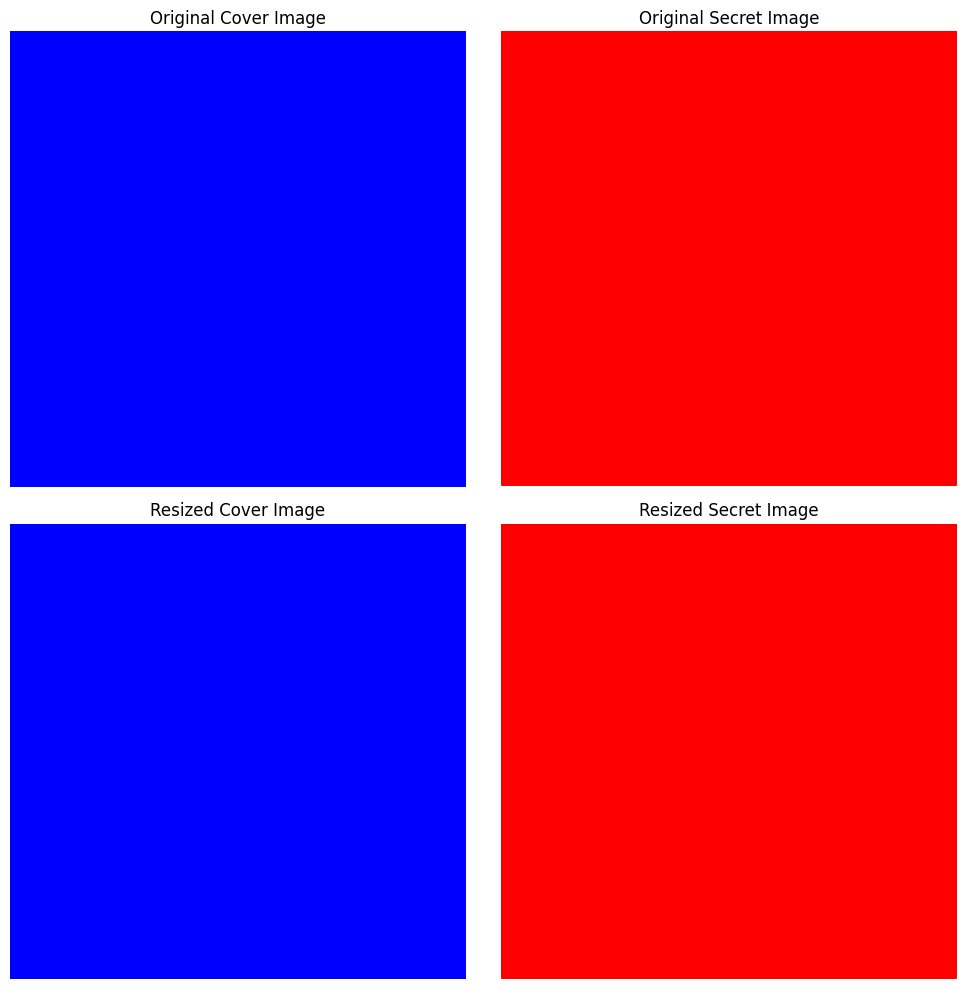

In [45]:
def crop_and_resize_img(img, target_dimensions):
    """Crop and resize image to target dimensions."""
    original_width, original_height = img.size
    target_ratio = target_dimensions[0] / target_dimensions[1]
    original_ratio = original_width / original_height

    if original_ratio > target_ratio:
        # Crop width to fit the new ratio
        new_width = int(original_height * target_ratio)
        new_height = original_height
    else:
        # Crop height to fit the new ratio
        new_width = original_width
        new_height = int(original_width / target_ratio)

    # Center cropping
    left = (original_width - new_width) / 2
    top = (original_height - new_height) / 2
    right = (original_width + new_width) / 2
    bottom = (original_height + new_height) / 2

    img = img.crop((left, top, right, bottom))
    img = img.resize(target_dimensions, Image.LANCZOS)
    return img

# Load the images
cover_img = Image.open(r"Images/Blue.png")
secret_img = Image.open(r"Images/red.jpg")

# Resize both images
resized_cover_img = crop_and_resize_img(cover_img, (1080, 1080))
resized_secret_img = crop_and_resize_img(secret_img, (1080, 1080))

# Setup plot
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(cover_img)
ax[0, 0].set_title("Original Cover Image")
ax[0, 0].axis('off')

ax[0, 1].imshow(secret_img)
ax[0, 1].set_title("Original Secret Image")
ax[0, 1].axis('off')

ax[1, 0].imshow(resized_cover_img)
ax[1, 0].set_title("Resized Cover Image")
ax[1, 0].axis('off')

ax[1, 1].imshow(resized_secret_img)
ax[1, 1].set_title("Resized Secret Image")
ax[1, 1].axis('off')

plt.tight_layout()
plt.show()


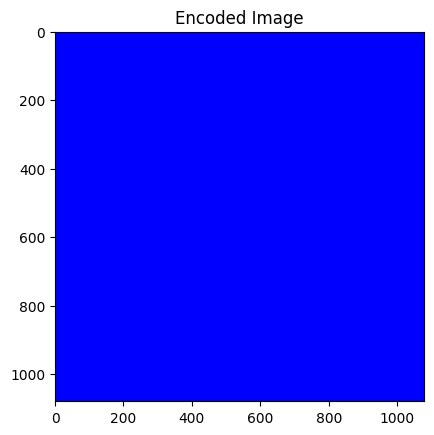

No hidden image found.
No hidden image found.


In [49]:
from PIL import Image
import matplotlib.pyplot as plt

def bin_to_image(binary, size):
    """Convert binary data to an image."""
    binary_list = [binary[i:i+8] for i in range(0, len(binary), 8)]
    pixels = [int(b, 2) for b in binary_list]
    img = Image.new('RGB', size)
    img.putdata(list(zip(*[iter(pixels)]*3)))
    return img

def apply_key(binary, key):
    """Apply XOR operation to binary data with a repeating key."""
    key = (key * (len(binary) // len(key) + 1))[:len(binary)]
    return ''.join(str(int(b) ^ int(k)) for b, k in zip(binary, key))

def decode_image(encoded_path, secret_size, key, save_path):
    img = Image.open(encoded_path)
    binary_message = ''
    width, height = img.size

    # Display the encoded image
    plt.imshow(img)
    plt.title("Encoded Image")
    plt.show()

    for y in range(height):
        for x in range(width):
            pixel = img.getpixel((x, y))
            for n in range(3):  # Assuming RGB
                binary_message += format(pixel[n] & 1, 'b')
                if binary_message[-16:] == '1111111111111110':  # Check for delimiter
                    # Cut off the delimiter and any extra bits
                    binary_message = binary_message[:-(16 + ((len(binary_message) - 16) % (secret_size[0] * secret_size[1] * 3 * 8)))]
                    binary_message = apply_key(binary_message, key)
                    secret_image = bin_to_image(binary_message, secret_size)
                    secret_image.save(save_path)
                    print(f"Secret image saved as: {save_path}")
                    return secret_image
    print("No hidden image found.")
    return None

# Example usage:
encoded_path = r"Encoded Images/imageRB_1010101010.png"  # Adjust path if needed
secret_size = (1080, 1080)  # Adjust to the correct size known for the secret image
key = "1010101010"
save_path = "secret_imageRB.png"
decoded_image = decode_image(encoded_path, secret_size, key, save_path)
if decoded_image:
    plt.imshow(decoded_image)
    plt.title("Decoded Secret Image")
    plt.show()
else:
    print("No hidden image found.")
